In [1]:
import numpy as np,matplotlib.pyplot as plt,pandas as pd, seaborn as sn

In [2]:
SP500_quart_rate = pd.read_csv('SP500_quart_rate.csv',header=0,names=['DATE','SP500_Change'])
inflation_quart_rate = pd.read_csv('inflation_quart_rate.csv',header=0,names=['DATE','Inflation_Val','Inflation_Change'])
treasury_bond_quart_rate = pd.read_csv('treasury_bond_quart_rate.csv',header=0,names=['DATE','Treasury_Rate','Treasury_Rate_Change'])
home_price_quart_rate = pd.read_csv('home_price_quart_rate.csv',header=0,names=['DATE','Home_Price_Index','Home_Price_Change'])
mortgage_quart_rate = pd.read_csv('mortgage_quart_rate.csv',header=0,names=['DATE','Mortgage_Rate','Mortgage_Rate_Change'])
rent_quart_rate = pd.read_csv('rent_quart_rate.csv',header=0,names=['DATE','Rent_Index','Rent_Change'])
vacancy_quart_rate = pd.read_csv('vacancy_quart_rate.csv',header=0,names=['DATE','Vacancy_Rate','Vacancy_Rate_Change'])
SP500_quart_rate.head()

,DATE,SP500_Change
0,4/1/1871,0.082207
1,7/1/1871,0.011603
2,10/1/1871,-0.015856
3,1/1/1872,0.072985
4,4/1/1872,0.079733


In [3]:
merged_df = SP500_quart_rate.merge(inflation_quart_rate, how='left',left_on='DATE', right_on='DATE')
merged_df = merged_df.merge(treasury_bond_quart_rate, how='left',left_on='DATE', right_on='DATE')
merged_df = merged_df.merge(home_price_quart_rate, how='left',left_on='DATE', right_on='DATE')
merged_df = merged_df.merge(mortgage_quart_rate, how='left',left_on='DATE', right_on='DATE')
merged_df = merged_df.merge(rent_quart_rate, how='left',left_on='DATE', right_on='DATE')
merged_df = merged_df.merge(vacancy_quart_rate, how='left',left_on='DATE', right_on='DATE')
# merged_df.drop(columns=['Inflation_Val','Treasury_Rate','Mortgage_Rate','Vacancy_Rate'],inplace=True)
merged_df.describe()

,SP500_Change,Inflation_Val,Inflation_Change,Treasury_Rate,Treasury_Rate_Change,Home_Price_Index,Home_Price_Change,Mortgage_Rate,Mortgage_Rate_Change,Rent_Index,Rent_Change,Vacancy_Rate,Vacancy_Rate_Change
count,605.000000,226.000000,226.000000,241.000000,241.000000,189.000000,189.000000,204.000000,204.000000,301.000000,301.000000,265.000000,265.000000
mean,0.025429,0.991225,2.048323,0.059338,0.004182,244.850899,0.012510,7.772555,0.000178,132.192162,0.008940,7.306038,0.000629
std,0.080675,0.953034,45.948455,0.029919,0.105837,124.054913,0.014110,3.294736,0.062679,97.480651,0.005044,1.503141,0.044940
min,-0.269888,-3.959670,-296.181091,0.006506,-0.496250,60.980000,-0.031516,2.760714,-0.134924,25.300000,-0.000420,5.000000,-0.136364
25%,-0.015856,0.482654,-0.681127,0.038921,-0.053154,142.460000,0.007493,5.048077,-0.039877,41.266667,0.005618,5.900000,-0.028571
50%,0.026396,0.924664,-0.127044,0.057461,0.002023,215.270000,0.012348,7.438462,-0.007321,107.666667,0.008236,7.300000,0.000000
75%,0.071714,1.491494,0.417322,0.076738,0.044513,343.030000,0.017778,9.569808,0.030036,206.100000,0.011752,8.200000,0.030612
max,0.646952,4.368953,524.908290,0.148384,0.545259,617.890000,0.067942,17.735714,0.377742,365.331333,0.034749,11.100000,0.142857


                      SP500_Change  Inflation_Val  Inflation_Change  \
SP500_Change              0.006508       0.003597         -0.351963   
Inflation_Val             0.003597       0.908275         -4.705048   
Inflation_Change         -0.351963      -4.705048       2111.260480   
Treasury_Rate             0.000019       0.011042         -0.091689   
Treasury_Rate_Change      0.001075       0.034461          0.181097   
Home_Price_Index         -0.633781     -31.771027        304.023393   
Home_Price_Change         0.000097       0.004009         -0.034101   
Mortgage_Rate            -0.001492       1.168763         -8.514065   
Mortgage_Rate_Change     -0.000203       0.025018          0.169362   
Rent_Index               -0.066725     -30.850848        313.434819   
Rent_Change              -0.000027       0.001691         -0.002547   
Vacancy_Rate             -0.000472      -0.611159         -1.667029   
Vacancy_Rate_Change       0.000257       0.001750          0.076386   

     

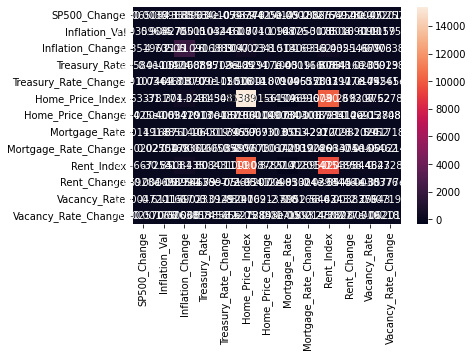

In [4]:
covMatrix = pd.DataFrame.cov(merged_df)
print (covMatrix)
sn.heatmap(covMatrix, annot=True, fmt='g')
plt.show()

In [5]:
averages = merged_df.mean()

C:\Users\kellychris\AppData\Local\Temp\ipykernel_33916\4237385140.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  averages = merged_df.mean()


In [6]:
covMatrix_np = np.array(covMatrix)
mu = np.array(averages)
num_samples = 200
rng = np.random.default_rng()
gen_data = rng.multivariate_normal(mu, covMatrix_np, size=num_samples)

C:\Users\kellychris\AppData\Local\Temp\ipykernel_33916\3078853114.py:5: RuntimeWarning: covariance is not positive-semidefinite.
  gen_data = rng.multivariate_normal(mu, covMatrix_np, size=num_samples)


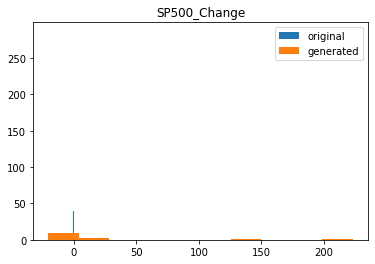

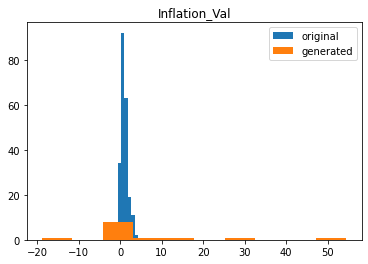

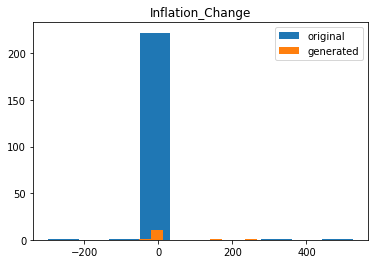

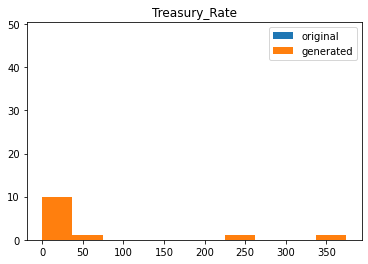

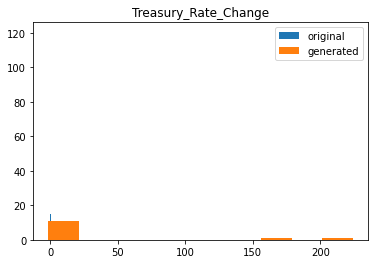

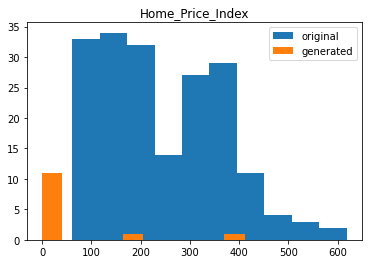

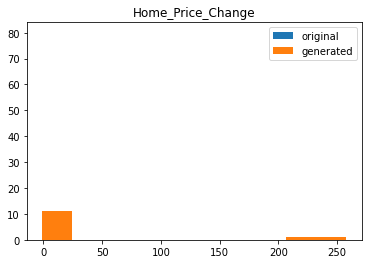

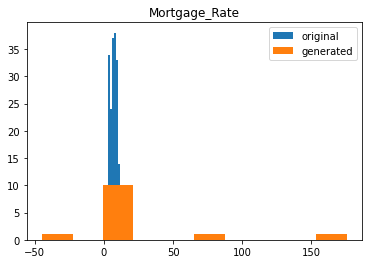

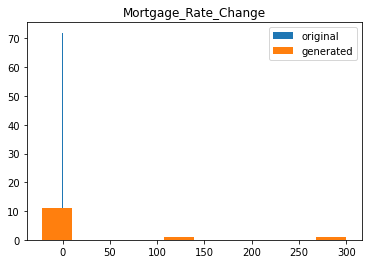

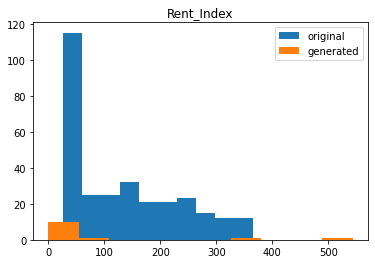

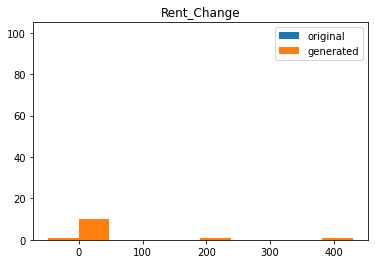

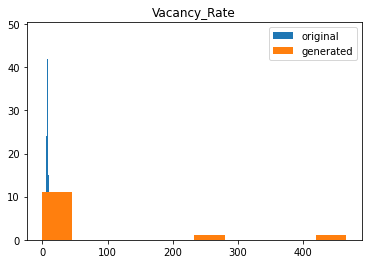

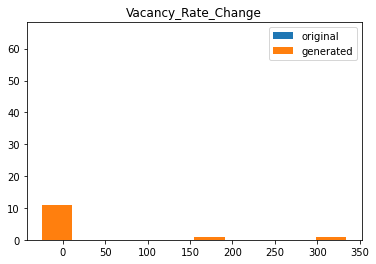

In [7]:
for idx, col in enumerate(merged_df.drop(columns='DATE').columns):
    plt.figure()
    plt.title(col)
    plt.hist(merged_df[col],label='original')
    plt.hist(gen_data[idx],label='generated')
    plt.legend()